# 0 installing necessary modules

In [155]:

!pip install --upgrade pip
!pip install torch torchvision numpy opencv-python requests pillow grad-cam matplotlib


  Using cached pip-24.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\kashi\virtualenv\AI_Projects\Scripts\python.exe -m pip install --upgrade pip


# 1. Importing necessary modules

In [156]:
import torchvision
import warnings
import torch
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from PIL import Image

import matplotlib.pyplot as plt

## 1.1 importing modules from pytorch_grad_cam

In [157]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

### 1.1.1 importing modules for visualisation

In [158]:
from pytorch_grad_cam.grad_cam_plusplus import GradCAMPlusPlus
from pytorch_grad_cam.eigen_cam import EigenCAM
from pytorch_grad_cam.score_cam import ScoreCAM
from pytorch_grad_cam.xgrad_cam import XGradCAM
from pytorch_grad_cam import GradCAM

# 2. Defining necessary functions

In [159]:
def image_transform(image_url):
    """
    Transforms an image from a given URL into a preprocessed image tensor suitable for model input.

    Parameters:
    - image_url (str): The URL of the image to be transformed.

    Returns:
    - img (numpy.ndarray): The resized image as a numpy array, normalized to the range [0, 1].
    - input_tensor (torch.Tensor): The preprocessed image tensor ready for model input, normalized using the specified mean and standard deviation.

    Process:
    1. The image is loaded from the provided URL.
    2. The image is resized to 224x224 pixels.
    3. The pixel values are scaled to the range [0, 1].
    4. The image is normalized using the specified mean and standard deviation.
    """
    img = np.array(Image.open(requests.get(image_url, stream=True).raw))
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return img, input_tensor


In [160]:
def predict_and_get_target_class(model, input_tensor):
    """
    Predicts the class of the given input tensor using the provided model and returns the target class.

    Parameters:
    - model (torch.nn.Module): The neural network model used for making predictions.
    - input_tensor (torch.Tensor): The preprocessed image tensor from image_transfor function to be classified by the model.

    Returns:
    - predicted_class (list): A list containing the predicted class index.

    Process:
    1. Passes the input tensor through the model to get the output.
    2. Determines the index of the highest value in the output tensor(using argmax) , which corresponds to the predicted class.
    3. Returns the predicted class index as a list(list of one value).
    """
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = [torch.argmax(output).item()]
    return predicted_class


In [161]:
def get_conv_layer(model):
    """
    Retrieves a specified convolutional layer from the given neural network model based on user input.

    Parameters:
    - model (torch.nn.Module): The neural network model to search through.

    Returns:
    - torch.nn.Conv2d: The selected convolutional layer based on user input.

    Process:
    1. Collects all convolutional layers (`torch.nn.Conv2d`) from the model.
    2. Prints the total number of convolutional layers found.
    3. Prompts the user to input the index of the convolutional layer they wish to visualize.
    4. Checks if the user input is a valid layer number.
    5. Returns the convolutional layer.
    6. If the input is not valid, prints an error message.

    Note:
    - If there are no convolutional layers in the model, the function will not prompt for user input and will not return any layer.
    """
    conv_layers = [layer for layer in model.modules() if isinstance(layer, torch.nn.Conv2d)]
    input_layer = int(input(f'There are {len(conv_layers)} conv2d layers in this network, which layer you want to visualize? '))
    if input_layer <= 0 :
        return f'Please enter positive layer number'
    
    elif input_layer > len(conv_layers):
        return f'Please enter proper layer number'
    else:
        return conv_layers[input_layer - 1]


# 3. importing image and model

In [162]:
model = models.densenet121(pretrained=True)
#model.eval()

In [163]:
image_url='https://media.istockphoto.com/id/492696926/photo/wood-mouse-on-root-of-tree.jpg?s=612x612&w=0&k=20&c=vHJ24llld5HiUz10mQAOzQfnQz-LE2Xg5wBYM4S1zX0='
img,input_tensor=image_transform(image_url)

### 3.1.1 making prediction with the model

In [164]:
predict_and_get_target_class(model,input_tensor)

[463]

### 3.1.2 saving the target label number

In [165]:
targets =[ClassifierOutputTarget(predict_and_get_target_class(model, input_tensor))]

### 3.1.3 getting the convolutional layer

In [166]:
target_layers = get_conv_layer(model)
target_layers

Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

# 4. appling the gradcam methods

## 4.1 normal grad cam

In [167]:

with GradCAM(model=model, target_layers=[target_layers]) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    grad_cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

## 4.2 GradCAM++

In [168]:
cam2=GradCAMPlusPlus(model=model, target_layers=[target_layers])
grayscale_cams2=cam2(input_tensor=input_tensor)
grayscale_cam2 = grayscale_cams2[0, :]
gradcamplusplus_image=show_cam_on_image(img,grayscale_cam2,use_rgb=True)


## 4.3 EigenCAM

In [169]:
cam3=EigenCAM(model=model,target_layers=[target_layers])
grayscale_cams3=cam3(input_tensor=input_tensor)
grayscale_cam3=grayscale_cams3[0, :]
eigencam_image=show_cam_on_image(img,grayscale_cam3,use_rgb=True)

## 4.4 ScoreCAM

In [170]:
'''cam4=ScoreCAM(model=model,target_layers=target_layers)
grayscale_cams4=cam4(input_tensor=input_tensor)
grayscale_cam4=grayscale_cams4[0, :]
cam4_image=show_cam_on_image(img,grayscale_cam4,use_rgb=True)'''

'cam4=ScoreCAM(model=model,target_layers=target_layers)\ngrayscale_cams4=cam4(input_tensor=input_tensor)\ngrayscale_cam4=grayscale_cams4[0, :]\ncam4_image=show_cam_on_image(img,grayscale_cam4,use_rgb=True)'

## 4.5 XGradCAM

In [171]:
cam5=XGradCAM(model=model,target_layers=[target_layers])
grayscale_cams5=cam5(input_tensor=input_tensor)
grayscale_cam5=grayscale_cams5[0, :]
xgradcam_image=show_cam_on_image(img,grayscale_cam5,use_rgb=True)

# 5. visualizing

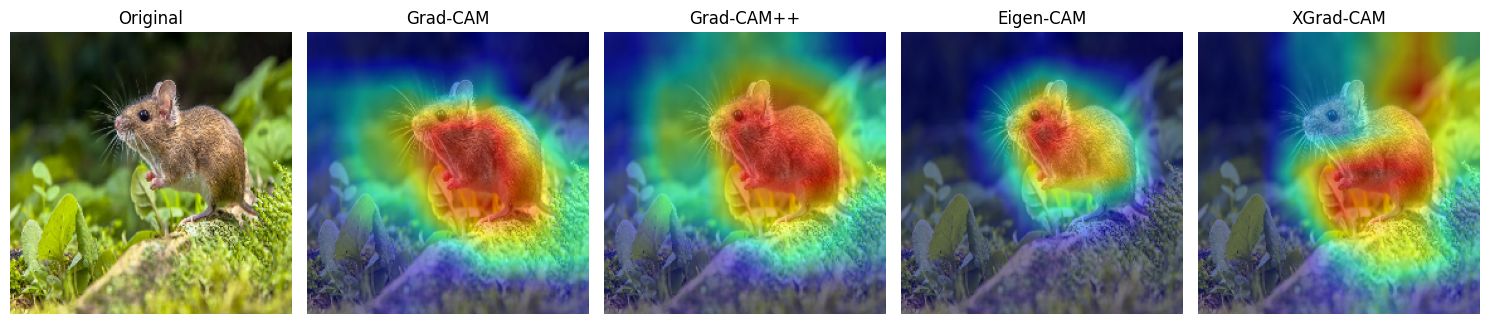

In [174]:
# with the help of chatgpt we were able to label the images
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
labels = ['Original', 'Grad-CAM', 'Grad-CAM++', 'Eigen-CAM', 'XGrad-CAM']
imagess = np.hstack((np.uint8(255*img), grad_cam_image, gradcamplusplus_image,eigencam_image,xgradcam_image))
fig, axes = plt.subplots(1, len(labels), figsize=(15, 5)) 
for ax, image, label in zip(axes, [img, grad_cam_image, gradcamplusplus_image, eigencam_image, xgradcam_image], labels):
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()